In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import pickle
import nltk
import seaborn as sns
import os
import re 
import sklearn.manifold
from collections import Counter
from nltk.cluster import kmeans, cosine_distance
from gensim.models import Word2Vec

In [3]:
from clustering.embedding import WordEmbedding

In [4]:
#!python -m spacy download es_core_news_sm
#!python -m spacy download es_core_news_md
#nltk.download('punkt')
#nltk.download('wordnet')

In [5]:
df = pd.read_csv('datos_estructurados_malba')

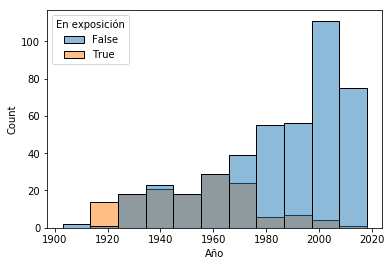

In [6]:
sns.histplot(data=df,x='Año',hue='En exposición',)

In [7]:
df.columns

Index(['URL_obra', 'Texto', 'URL_autor', 'Titulo', 'Año', 'Técnica', 'Medidas',
       'Nro. de inventario', 'Donación', 'En exposición', 'Duración'],
      dtype='object')

In [8]:
len(df['Técnica'].unique())

351

In [9]:
df['Técnica'].value_counts()

Óleo sobre tela                                                                    43
Copia heliográfica sobre papel. x/∞                                                25
Tinta sobre papel                                                                  15
Lápiz sobre papel                                                                  14
Cartón y papel pintado                                                             12
                                                                                   ..
Acero y motor a 220v en caja metálica esmaltada con interior de papel estampado     1
Madera, pintura, cartas                                                             1
Cuatro serigrafías sobre papel. Edición 1/5                                         1
Cerámica esmaltada y lustre de platino                                              1
Esmalte bajo plexiglás y receptáculo para peces de agua fría                        1
Name: Técnica, Length: 350, dtype: int64

In [10]:
textos = (df.dropna(subset=['Texto']).Texto.values)

In [11]:
len(textos)

277

In [12]:
texto = "".join(textos).strip()

In [13]:
len(texto)

1542053

# Preprocesamos

Vamos a preprocesar:
- Eliminamos los números de las notas al pie, que son los números precedidos por puntos (.2 Blahblah)
- Reemplazamos \n3, \n, s\p por espacios
- Separamos en oraciones
- Lowercase todo
- Nos deshacemos de caracteres especiales
- Nos deshacemos de oraciones muy cortas

In [14]:
#texto = "Texto de Agustin Díez Fischer\n\xa0\nNotas\n1."

In [15]:
texto_limpio = re.sub("\d?\\n\d?\.?", "", texto)
texto_limpio = re.sub("\.\d", ". ", texto_limpio)
texto_limpio = re.sub("s\/p\.", ". ", texto_limpio)
puntos_mal = re.findall(".?\.[A-Z]",texto_limpio)

In [16]:
for elem in puntos_mal:
    if len(elem) == 2:
        repl = (elem[0] + ' ' + elem[1])
    elif len(elem) == 3:
        repl = (elem[0] + elem[1] + ' ' + elem[2])
    texto_limpio = texto_limpio.replace(elem, repl)

# Utilizamos contexto de oraciones 

In [17]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize.punkt import PunktTrainer, PunktSentenceTokenizer

In [18]:
pt = PunktSentenceTokenizer(texto,verbose=True)

In [19]:
sentences = pt.tokenize(texto)

In [20]:
len(sentences)

7048

In [21]:
sentences_len = [len(s) for s in sentences]

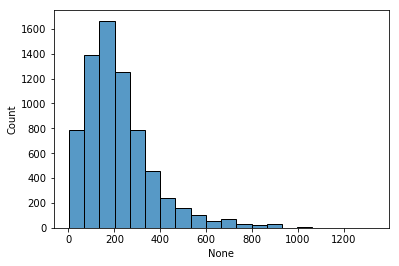

In [22]:
sns.histplot(x=sentences_len,bins=20)

In [23]:
sent_df = pd.DataFrame({'sent':sentences,'leng':sentences_len})

In [24]:
sent_df.sample(n=10)

,sent,leng
5962,"Los estilos del grupo son variados, y Hélio ya...",106
1860,"En la segunda mitad del siglo XIX, el artista ...",115
2887,"La experimentación, la libertad creativa y el ...",293
6473,"Es una casa abierta, para ser explorada por el...",58
4148,"Con el término cultura oriental, me refiero a ...",207
4897,"En este sentido, la vida nocturna, los eventos...",206
247,"), Abstract Art from the Río de la Plata.",41
5949,4.,2
2261,La numeración de los libros y su cantidad no r...,76
6101,"Los elementos a los que recurre, tales como la...",274


In [25]:
len_threshold = 30
mask = sent_df['leng'] < len_threshold

In [26]:
sent_df[mask].count()

sent    253
leng    253
dtype: int64

In [27]:
sent_df[mask].sample(n=30)

,sent,leng
223,El móvil.,9
2215,Florent Fajole.,15
2977,Retrospectiva.,14
6587,9.,2
6977,6.,2
3296,4.,2
5171,¿muerto?,8
3877,2.,2
5531,"Ibid., p. 47.\n4.",16
2273,"Cf. Gaze, Tim et.",17


In [28]:
sent_df_long = sent_df[~mask]

In [29]:
sentences = sent_df_long.sent.values

In [30]:
np.random.choice(sentences,size=20)

array(['La creación de instrumentos y las performances en conciertos también se sumaron a la nueva faceta que transitó el artista en aquellos años.',
       'No obstante, creo conveniente tomar el nombre que tuvo en el libro Buenos Aires 1936, donde se publicó por primera vez.',
       'Palmeiro, Cecilia, Desbunde y felicidad.',
       'Los artefactos cinéticos tenían algunos puntos en común con los productos del diseño industrial.',
       'Según los datos recogidos por la antropóloga Alcida Rita Ramos, solamente entre 1974 y 1975 una serie de enfermedades infecciosas mataron al 22% de la población de cuatro aldeas afectadas por las obras viales y, apenas dos años después, más del 50% de los habitantes de otras cuatro comunidades fallecieron debido a una epidemia de sarampión.',
       'En primer lugar, su concepto de “luz astral”.',
       'En esa ocasión, Jitrik había decidido renombrar sus pinturas con proclamas anarquistas que había recuperado durante los estudios que, desde 1995,

# Tokenizamos y limpiamos un poco más

In [31]:
nlp = spacy.load("es_core_news_sm")

In [32]:
def normalize(text):
    text = text.lower()
    # Quitamos los guiones y los reemplazamos por espacios
    text = re.sub('-', ' ', text)
    # Quitamos caracteres espaeciales excepto acentos y dieresis
    text = re.sub('[^A-Za-z0-9  áéíóúÁÉÍÓÚüÜïÏÿñ]+', '', text)
    return text

def keep_token(token):
    return t.isalpha()

def tokenize(text):
    tokens = text.split(' ')
    return [t for t in tokens if t.isalpha()]

In [33]:
sents_tokens = [tokenize(normalize(sent)) for sent in sentences]

In [34]:
sentences[2]

'Ejemplo paradigmático del artista global, ha observado y pensado las realidades metropolitanas de todo el mundo, ha hecho obras sobre fronteras y guerras, y también se ha fascinado con las formas y metáforas de ciertos fenómenos climáticos.'

In [35]:
sents_tokens[2]

['ejemplo',
 'paradigmático',
 'del',
 'artista',
 'global',
 'ha',
 'observado',
 'y',
 'pensado',
 'las',
 'realidades',
 'metropolitanas',
 'de',
 'todo',
 'el',
 'mundo',
 'ha',
 'hecho',
 'obras',
 'sobre',
 'fronteras',
 'y',
 'guerras',
 'y',
 'también',
 'se',
 'ha',
 'fascinado',
 'con',
 'las',
 'formas',
 'y',
 'metáforas',
 'de',
 'ciertos',
 'fenómenos',
 'climáticos']

In [36]:
sents_joined_tokens = [" ".join(s) for s in sents_tokens]

# Triplas de dependencia

In [37]:
nlp = spacy.load("es_core_news_sm")
nlp.max_length = 2000000

In [38]:
doc = nlp(texto_limpio)

In [39]:
sent_threshold = 30

In [40]:
sents = [sent for sent in doc.sents if len(sent) > sent_threshold]

words = []
words_lemma = []
for sent in sents:
    for word in sent:
        if word.is_alpha:
            words.append(word)
            words_lemma.append(word.lemma_)
            
counts = Counter(words_lemma)

In [41]:
len(counts)

13119

In [42]:
def parse_tags(word):
    tags = word.tag_[len(word.pos_) + 2:]
    tags = tags.split("|")
    return tags

lemma_file = open("clustering/lemmatization-es.txt", "r")
lemma_raw = lemma_file.read()
lemma = lemma_raw.split("\n")

In [43]:
lemma

['1\tprimer',
 '1\tprimera',
 '1\tprimeras',
 '1\tprimero',
 '1\tprimeros',
 '10\tdécima',
 '10\tdécimas',
 '10\tdécimo',
 '10\tdécimos',
 '100\tcentésima',
 '100\tcentésimas',
 '100\tcentésimo',
 '100\tcentésimos',
 '1000\tmilésima',
 '1000\tmilésimas',
 '1000\tmilésimo',
 '1000\tmilésimos',
 '10000\tdiezmilésima',
 '10000\tdiezmilésimas',
 '10000\tdiezmilésimo',
 '10000\tdiezmilésimos',
 '100000\tcienmilésima',
 '100000\tcienmilésimas',
 '100000\tcienmilésimo',
 '100000\tcienmilésimos',
 '1000000\tmillonésima',
 '1000000\tmillonésimas',
 '1000000\tmillonésimo',
 '1000000\tmillonésimos',
 '10000000\tdiezmillonésima',
 '10000000\tdiezmillonésimas',
 '10000000\tdiezmillonésimo',
 '10000000\tdiezmillonésimos',
 '100000000\tcienmillonésima',
 '100000000\tcienmillonésimas',
 '100000000\tcienmillonésimo',
 '100000000\tcienmillonésimos',
 '1000000000\tmilmillonésima',
 '1000000000\tmilmillonésimas',
 '1000000000\tmilmillonésimo',
 '1000000000\tmilmillonésimos',
 '10000000000\tdiezmilmillonés

In [44]:
lemma_dict = {}
for pair in lemma:
    w = pair.split("\t")
    if len(w) == 2:
        lemma_dict[w[1]] = w[0]

In [45]:
def lemmatize(word):
    if word in lemma_dict:
        word = lemma_dict[word]
    return word

In [46]:
len(words)

184933

In [47]:
# Crear diccionario
dicc = {}
list_dicc = {}
word_id = 0
threshold_w = 3
threshold_c = 1

for word in words:
    w = lemmatize(word.lemma_)
    if not word.is_alpha or str.isdigit(w) or counts[w] < threshold_w:
        continue
    if not w in dicc:
        features = {}
    else:
        features = dicc[w]

    pos = "POS__" + word.pos_
    if not pos in features:
        features[pos] = 0
    features[pos] += 1

    dep = "DEP__" + word.dep_
    if not dep in features:
        features[dep] = 0
    features[dep] += 1

    tags = parse_tags(word)
    for tag in tags:
        if not tag in features:
            features[tag] = 0
        features[tag] += 1

    if not word.i == 0:
        context_izq = doc[word.i - 1]
        c_izq = lemmatize(context_izq.lemma_)
        if context_izq.is_alpha and counts[c_izq] > threshold_c:
            if str.isdigit(c_izq):
                c_izq = "NUM__"
            if not c_izq in features:
                features[c_izq] = 0
            features[c_izq] += 1

    if not word.i < len(doc):
        context_der = doc[word.i + 1]
        c_der = lemmatize(context_der.lemma_)
        if context_der.is_alpha and counts[c_der] > threshold_c:
            if str.isdigit(c_der):
                c_der = "NUM__"
            if not c_der in features:
                features[c_der] = 0
            features[c_der] += 1

    tripla = "TRIPLA__" + w + "__" + word.lemma_ + "__" + word.dep_ + "__" + lemmatize(word.head.lemma_)
    if not tripla in features:
        features[tripla] = 0
    features[tripla] += 1

    word_id += 1

    dicc[w] = features

In [48]:
len(dicc)

4923

In [49]:
features = []
key_words = {}
wid = 0
for d in dicc:
    if len(d) > 0:
        key_words[d] = wid
        wid += 1
        features.append(dicc[d])

In [50]:
len(features)

4923

In [51]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
matrix = v.fit_transform(features)

In [52]:
matrix.shape

(4923, 81066)

In [53]:
matrix_normed = matrix / matrix.max(axis=0)

In [54]:
variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0))

In [55]:
threshold_v = 0.001
red_matrix = np.delete(matrix_normed, np.where(variances < threshold_v), axis=1)

In [56]:
red_matrix.shape

(4923, 154)

In [57]:
matrix_normed.shape

(4923, 81066)

In [58]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(red_matrix)

In [59]:

pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y"]
)

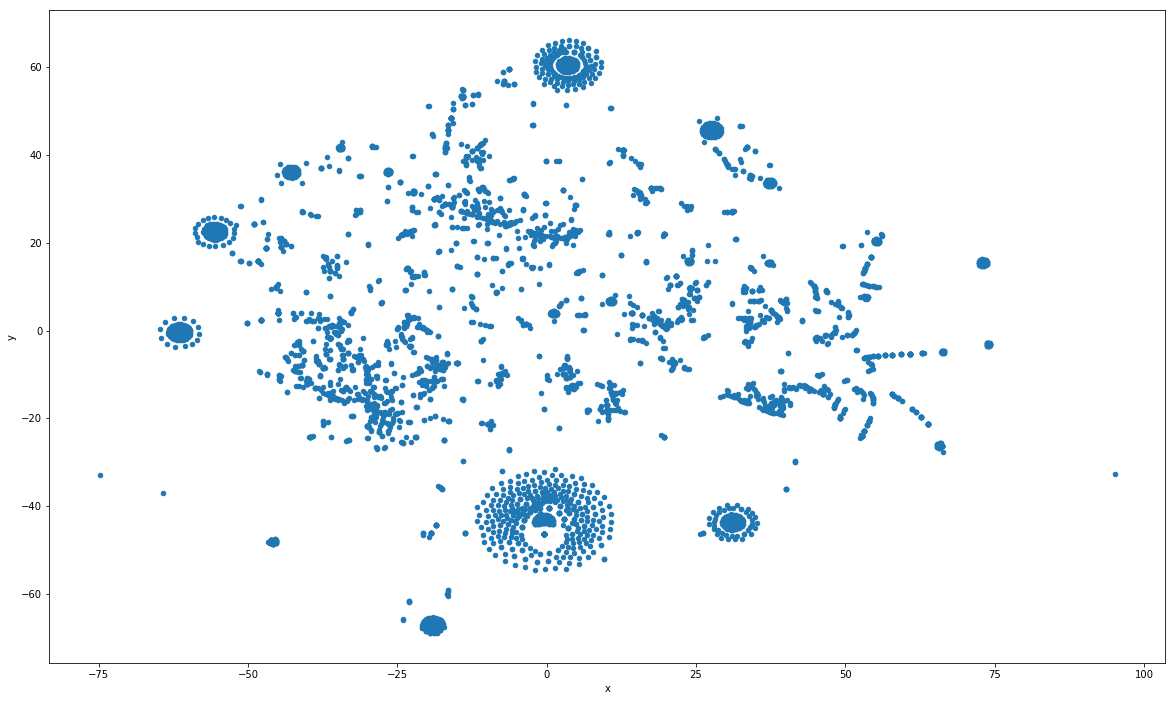

In [60]:

pointsspacy.plot.scatter("x", "y", s=20, figsize=(20, 12))

In [61]:
def plot_region(x_bounds, y_bounds):
    slice = pointsspacy[
        (x_bounds[0] <= pointsspacy.x) &
        (pointsspacy.x <= x_bounds[1]) & 
        (y_bounds[0] <= pointsspacy.y) &
        (pointsspacy.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', s=35, figsize=(20, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

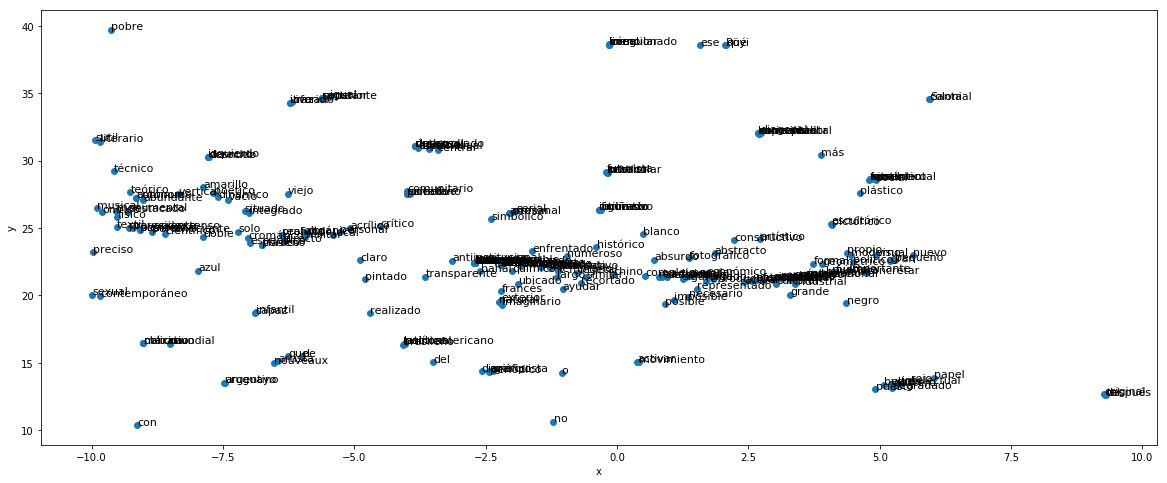

In [62]:
plot_region(x_bounds=(-10, 10), y_bounds=(10, 40))

In [63]:
def clustering(k):
    clusterer = kmeans.KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(red_matrix, True)
    return clusters

In [ ]:
c50 =  clustering(50)
c100 = clustering(100)
c150 = clustering(150)

/home/work/anaconda3/lib/python3.8/site-packages/nltk/cluster/util.py:131: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


In [ ]:
filename = "trained/lavoz_cluster50.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c50, fileObj)
fileObj.close()

In [ ]:
filename = "trained/lavoz_cluster100.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c100, fileObj)
fileObj.close()

In [ ]:
filename = "trained/lavoz_cluster150.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c150, fileObj)
fileObj.close()

In [ ]:
filename = "trained/lavoz_cluster100.pickle"
with open(filename, 'rb') as f:
    clusters = pickle.load(f)

In [ ]:
pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[key_words[word]], clusters[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y", "c"]
)

In [ ]:
pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

In [ ]:
def plot_region_cluster(x_bounds, y_bounds):
    slice = pointscluster[
        (x_bounds[0] <= pointscluster.x) &
        (pointscluster.x <= x_bounds[1]) & 
        (y_bounds[0] <= pointscluster.y) &
        (pointscluster.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

# Word2vec

In [ ]:
np.mean([len(s) for s in sents_tokens])

In [ ]:
windows_size = 7
vector_size = 40
min_count = 2
epochs = 200
w2v_model = Word2Vec(sents_tokens, size=vector_size, window=windows_size, min_count=min_count,iter=epochs, workers=4, seed=1)
w2v_model.save(f"word2vec_size={vector_size}__window={windows_size}__min_count={min_count}__epochs={epochs}.model")

In [ ]:
len(w2v_model.wv.index2word)

In [ ]:
w2v_model.wv.most_similar('animal',topn=10)

In [ ]:
w2v = WordEmbedding(wv=w2v_model.wv)

In [ ]:
w2v.plot_tsne_proyection()

# Fasttext

In [ ]:
from gensim.models.fasttext import FastText

In [ ]:
windows_size = 5
vector_size = 10
min_count = 2
epochs=50

In [ ]:
ft_model = FastText(
    size=vector_size, 
    window=windows_size,
    min_count=min_count,
)

In [ ]:
ft_model.build_vocab(sentences=sents_tokens)

In [ ]:
ft_model.train(sentences=sents_tokens, total_examples=len(sents_tokens), epochs=epochs)  # train
ft_model.save(f"fasttext__size={vector_size}__window={windows_size}__min_count={min_count}__epochs={epochs}.model")

In [ ]:
ft = WordEmbedding(wv=ft_model.wv)

In [ ]:
ft.plot_tsne_proyection(id_range=(0,1000))

Me gusta más Fasstext, incluso en la proyección ya se pueden observar cosas más interesantes

# Clustering

In [ ]:
n_clusters = 50

In [ ]:
ft.train_clustering(
    n_clusters=n_clusters,
    clustering_method='agglomerative')

In [ ]:
ft.print_clustering_results()

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

In [ ]:
kmeans.labels_

In [ ]:
from collections import defaultdict

In [ ]:
word_clusters = defaultdict(list)
for word,label in zip(ft_vectors.index2word , kmeans.labels_):
    word_clusters[label].append(word)

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

cmap = cm.viridis
norm = Normalize(vmin=0, vmax=n_clusters)

In [ ]:
word_by_cluster = {word:cluster for word,cluster in zip(ft_vectors.index2word,kmeans.labels_)}

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pylab as plt

# obtener las palabras más comunes en el corpus, entre la 200 y la 600
words = [word for word in model_wv.index2word[200:1000]]

# convertirlas a vector
embeddings = [model_wv[word] for word in words]

#  T-SNEde
words_embedded = TSNE(n_components=2, random_state=1).fit_transform(embeddings)

# ... and visualize!
plt.figure(figsize=(20, 20))
for i, label in enumerate(words):
    x, y = words_embedded[i, :]
    cluster_color = cmap(norm(word_by_cluster[label]))
    plt.scatter(x, y, c=cluster_color)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                 ha='right', va='bottom', size=11)
plt.show()

# Conversion a vector de TFIDF de oraciones

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
nltk_stopwords = nltk.corpus.stopwords.words('spanish')

In [ ]:
tfidf = TfidfVectorizer(stop_words=nltk_stopwords,min_df=2)

In [ ]:
tfidf_sents = [" ".join(sent) for sent in norm_sents]

In [ ]:
tfidf_matrix = tfidf.fit_transform(tfidf_sents)

### Construiimos el vector de cada palabra como su ocurrencia en oraciones

In [ ]:
word_matrix = tfidf_matrix.transpose()

In [ ]:
word_matrix

# AgglomerativeClustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
agc = AgglomerativeClustering(
    affinity='cosine',
    n_clusters=100,
    linkage='average')

In [ ]:
agc.n_clusters_

In [ ]:
clusters = agc.fit_predict(word_matrix.toarray())